In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pprint import pprint
import spacy
from spacy.tokenizer import _get_regex_pattern
import nltk
from nltk.corpus import stopwords
import re
from spacy.matcher import Matcher
import spacy
from spacymoji import Emoji
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.feature_extraction.text import CountVectorizer

## Tinder Swindler 100k Tweets

In [191]:
# load the dataset
file = './TinderSwindlerVersion2.csv'
df = pd.read_csv(file)

In [192]:
df.head(10)

,user_name,user_location,user_created,user_followers,user_verified,date,text,source,is_retweet
0,globalnode.saito 🟥🐳🐈‍⬛,Travelling the World on Web3,2009-06-03 20:18:22+00:00,768,False,2022-02-09 17:09:22+00:00,"@T1gmee Tinder Swindler, off Netflix",Twitter for iPhone,False
1,Ungovernable 🇧🇮,NaN,2011-09-04 22:46:26+00:00,385,False,2022-02-09 17:09:18+00:00,"#tinderswindler , basically homeboy got away w...",Twitter for iPhone,False
2,Adefolake,NaN,2009-06-02 14:18:44+00:00,1994,False,2022-02-09 17:09:17+00:00,Not the tinder swindler becoming a TIk Tok sta...,Twitter for iPhone,False
3,✧ ☽,Noord-Brabant,2012-02-12 07:35:26+00:00,336,False,2022-02-09 17:09:07+00:00,Why isn’t Shimon Hayut in jail ????? #thetinde...,Twitter for iPhone,False
4,chivo. 🥶,PG/MD,2010-03-22 21:23:17+00:00,1046,False,2022-02-09 17:09:06+00:00,the tinder swindler a sick nigga 😂😂,Twitter Web App,False
5,kira,"Toronto, Ontario",2010-07-02 12:50:53+00:00,362,False,2022-02-09 17:09:03+00:00,No those women on the Tinder swindler pissed m...,Twitter for iPhone,False
6,fogmistress698,NaN,2020-05-05 08:47:57+00:00,210,False,2022-02-09 17:08:55+00:00,This manipulation is how scammers pull you in ...,Twitter Web App,False
7,melraunch,"East, England",2019-05-24 23:18:01+00:00,3268,False,2022-02-09 17:08:45+00:00,@robertstweets1 @DistantFixed I waited for him...,Twitter for iPhone,False
8,Pamela Power,"Johannesburg, South Africa",2009-07-10 12:51:24+00:00,6306,False,2022-02-09 17:08:41+00:00,Hmmm...he's like the #tinderswindler https://t...,Twitter for Android,False
9,CaliMcCormac,NaN,2022-02-09 16:48:06+00:00,0,False,2022-02-09 17:08:40+00:00,Wow just watching the Twitter Swindler and it ...,Twitter for iPhone,False


### Data Cleansing

In [193]:
df.isna().sum()

user_name             5
user_location     18481
user_created          0
user_followers        0
user_verified         0
date                  0
text                  0
source                0
is_retweet            0
dtype: int64

In [194]:
df["user_name"].fillna('unknown', inplace=True)
df["user_location"].fillna('unknown', inplace=True)

In [195]:
# Remove urls from tweets
df.text = df.text.apply(lambda text: re.sub(r'http\S+|http', '', text))

In [196]:
df = df[df.is_retweet != True]

In [197]:
df.describe(include= "O").T

,count,unique,top,freq
user_name,76213,49767,.,196
user_location,76213,17911,unknown,18485
user_created,76213,54501,2020-10-06 00:15:38+00:00,160
date,76213,70999,2022-02-07 21:13:06+00:00,5
text,76213,73948,The Tinder Swindler,69
source,76213,210,Twitter for iPhone,47828


In [198]:
df_sample = df.sample(10000)

### Load Spacy and init stop words

In [199]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("emoji", first=True)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add patterns for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexanderkneis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [200]:
# extend stop words if needed
stop_words.extend(['\n', "\n\n"])

In [201]:
no_stop_words = [
    'not'
]

for w in no_stop_words:
    nlp.vocab[w].is_stop = False

#### Create docs via spacy
Follow along [this](https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a) guide for more details about each single step

In [202]:
# custom extended abbreviations
custom_abbreviations = {"bdrm": "bedroom"}

def normalize(text):
    # choosing BrE variety here since majority of posts are from the UK
        try:
            return ' '.join(normalise(text, variety="BrE", user_abbrevs=custom_abbreviations, verbose=False))
        except:
            return text

In [203]:
df_sample.text.apply(normalize)

22504    I hope they feed this dude to some cannibals.\...
57472    Quick question is Tinder Swindler based off a ...
54898    All these Twitter Swindler spoilers...I was th...
50702                        「 #厨二病発作の時間 」（clown_swindler）
37248    Reigniting the dying spark of love/ Do you sti...
                               ...                        
63455    #TheTinderSwindler wowza. How does one guy jug...
29461    Oh helllll no #tinderswindler my credit card??...
11492    Why and how did piotr get attacked? #tinderswi...
27003    I just started #TheTinderSwindler this chick i...
17843    Simon from Tinder Swindler was next level fine...
Name: text, Length: 10000, dtype: object

In [204]:
# create docs list with nlp
docs = [d for d in nlp.pipe(df_sample.text, n_process=6)]

In [205]:
def remove_stop_words(doc):
    return [t for t in doc if not t.is_stop]

In [206]:
# python based removal
def remove_punct(doc):
    return [t for t in doc if t.text not in string.punctuation]

In [324]:
def remove_hashtag(doc):
    return [t for t in doc if not t.text.startswith('#')]

In [328]:
def remove_annotations(doc):
    return [t for t in doc if not t.text.startswith('@')]

In [356]:
def remove_linebreaks(doc):
    return [t for t in doc if not "\n" in t.text]

In [207]:
def lemmatize(doc):
    return ' '.join([t.lemma_ for t in doc])

In [372]:
def lemmatize_token(doc):
    return [t.lemma_ for t in doc]

In [373]:
def preprocess_text(doc, keep_token):
        removed_punct = remove_punct(doc)
        removed_stop_words = remove_stop_words(removed_punct)
        removed_hashtag = remove_hashtag(removed_stop_words)
        removed_annotations = remove_annotations(removed_hashtag)
        removed_linebreaks = remove_linebreaks(removed_annotations)
        if keep_token:
                return lemmatize_token(removed_linebreaks)
        else:
                return lemmatize(removed_linebreaks)

In [374]:
pre_proccesed_texts = [preprocess_text(doc, False) for doc in docs]

In [375]:
pre_proccesed_texts[0]

'hope feed dude cannibal'

In [376]:
pre_proccesed_docs = [preprocess_text(doc, True) for doc in docs]

### Get Hashtags and Emoji

In [212]:
matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]
matcher.add('HASHTAG', [pattern])

def getHashtags(doc):
    matches = matcher(doc)
    hashtags = []
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        text = re.sub('[^A-Za-z0-9_-]+', '', span.text)
        hashtags.append(text)
    return hashtags

# getHashtags(docs[15])
# >>> ['tinderswindler']

In [213]:
# create list of hastags
hashtags = [item for sublist in list(getHashtags(doc) for doc in docs) for item in sublist]

In [214]:
counter = Counter()

for tag in hashtags:
    counter[tag] += 1

top_15_hashtags = counter.most_common(15)

In [215]:
df_hashtags = pd.DataFrame.from_records(top_15_hashtags, columns =['hashtag', 'count'])

In [216]:
df_hashtags

,hashtag,count
0,tinderswindler,2139
1,TheTinderSwindler,1410
2,TinderSwindler,355
3,Netflix,77
4,simonleviev,41
5,thetinderswindler,31
6,SimonLeviev,17
7,TindlerSwindler,17
8,netflix,14
9,NFT,12


In [217]:
def getEmoji(doc):
    emojis = set()
    if doc._.has_emoji:
        for emoji in doc._.emoji:
                emojis.add((emoji[0],emoji[2])) 

    return emojis

In [218]:
# create list of emojis
emojis = [item for sublist in list(getEmoji(doc) for doc in docs) for item in sublist]

In [219]:
counter = Counter()

for emoji in emojis:
    counter[emoji] += 1

top_15_emoji = (counter.most_common(15))

In [220]:
top_15_emoji

[(('😂', 'face with tears of joy'), 615),
 (('😭', 'loudly crying face'), 385),
 (('🤣', 'rolling on the floor laughing'), 323),
 (('🤯', 'exploding head'), 131),
 (('💀', 'skull'), 104),
 (('😩', 'weary face'), 92),
 (('😳', 'flushed face'), 90),
 (('😅', 'grinning face with sweat'), 62),
 (('🥴', 'woozy face'), 52),
 (('👀', 'eyes'), 44),
 (('🚩', 'triangular flag'), 43),
 (('🤔', 'thinking face'), 39),
 (('😱', 'face screaming in fear'), 35),
 (('🙄', 'face with rolling eyes'), 27),
 (('🔥', 'fire'), 26)]

In [221]:
flatted_emojis = []

for emoji in top_15_emoji:
    flatted_emoji = []
    for entry in emoji:
        if hasattr(entry, '__iter__'):
            for i in entry:
                flatted_emoji.append(i)
        else:
            flatted_emoji.append(entry)
    flatted_emojis.append(flatted_emoji)

print(flatted_emojis)
    
   


[['😂', 'face with tears of joy', 615], ['😭', 'loudly crying face', 385], ['🤣', 'rolling on the floor laughing', 323], ['🤯', 'exploding head', 131], ['💀', 'skull', 104], ['😩', 'weary face', 92], ['😳', 'flushed face', 90], ['😅', 'grinning face with sweat', 62], ['🥴', 'woozy face', 52], ['👀', 'eyes', 44], ['🚩', 'triangular flag', 43], ['🤔', 'thinking face', 39], ['😱', 'face screaming in fear', 35], ['🙄', 'face with rolling eyes', 27], ['🔥', 'fire', 26]]


In [222]:
# create DataFrame using data
df_emoji = pd.DataFrame.from_records(flatted_emojis, columns =['emoji',"desc", 'count'])

In [223]:
df_emoji

,emoji,desc,count
0,😂,face with tears of joy,615
1,😭,loudly crying face,385
2,🤣,rolling on the floor laughing,323
3,🤯,exploding head,131
4,💀,skull,104
5,😩,weary face,92
6,😳,flushed face,90
7,😅,grinning face with sweat,62
8,🥴,woozy face,52
9,👀,eyes,44


### First explorative Analysis

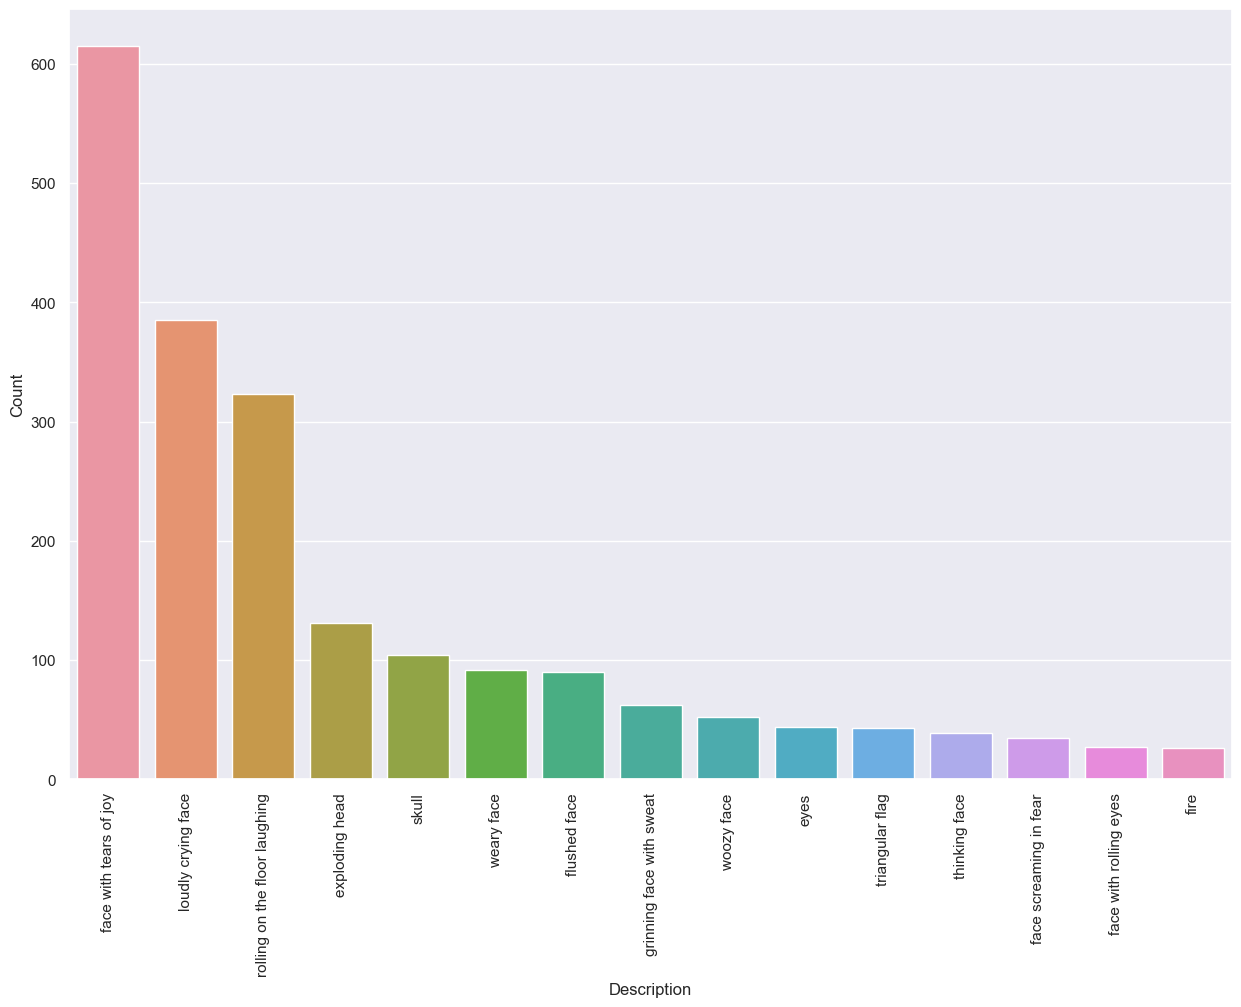

In [361]:
from pathlib import Path
import matplotlib as mpl

plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="desc",y="count", data=df_emoji)
ax.set_xlabel("Description")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


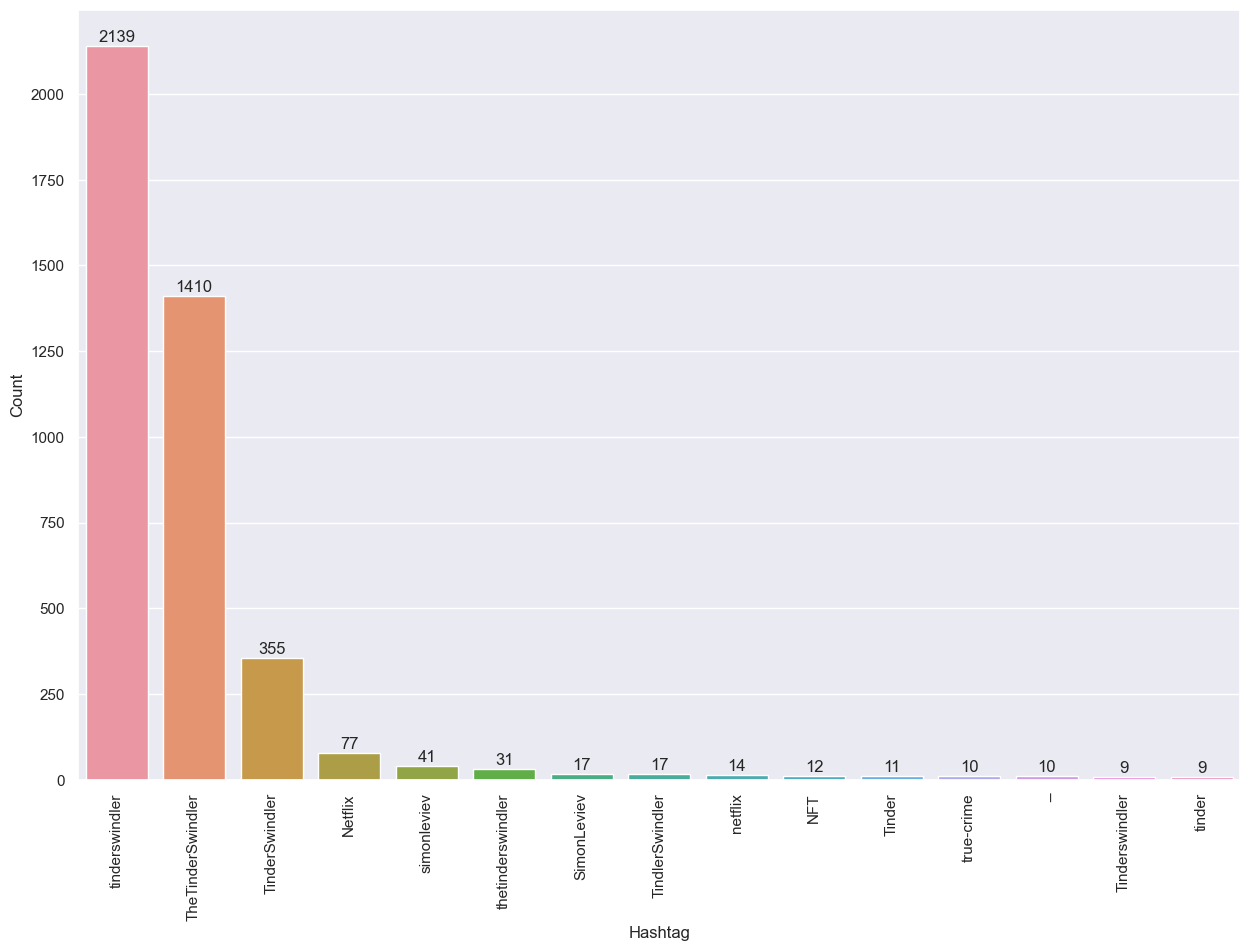

In [362]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="hashtag",y="count", data=df_hashtags)


for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


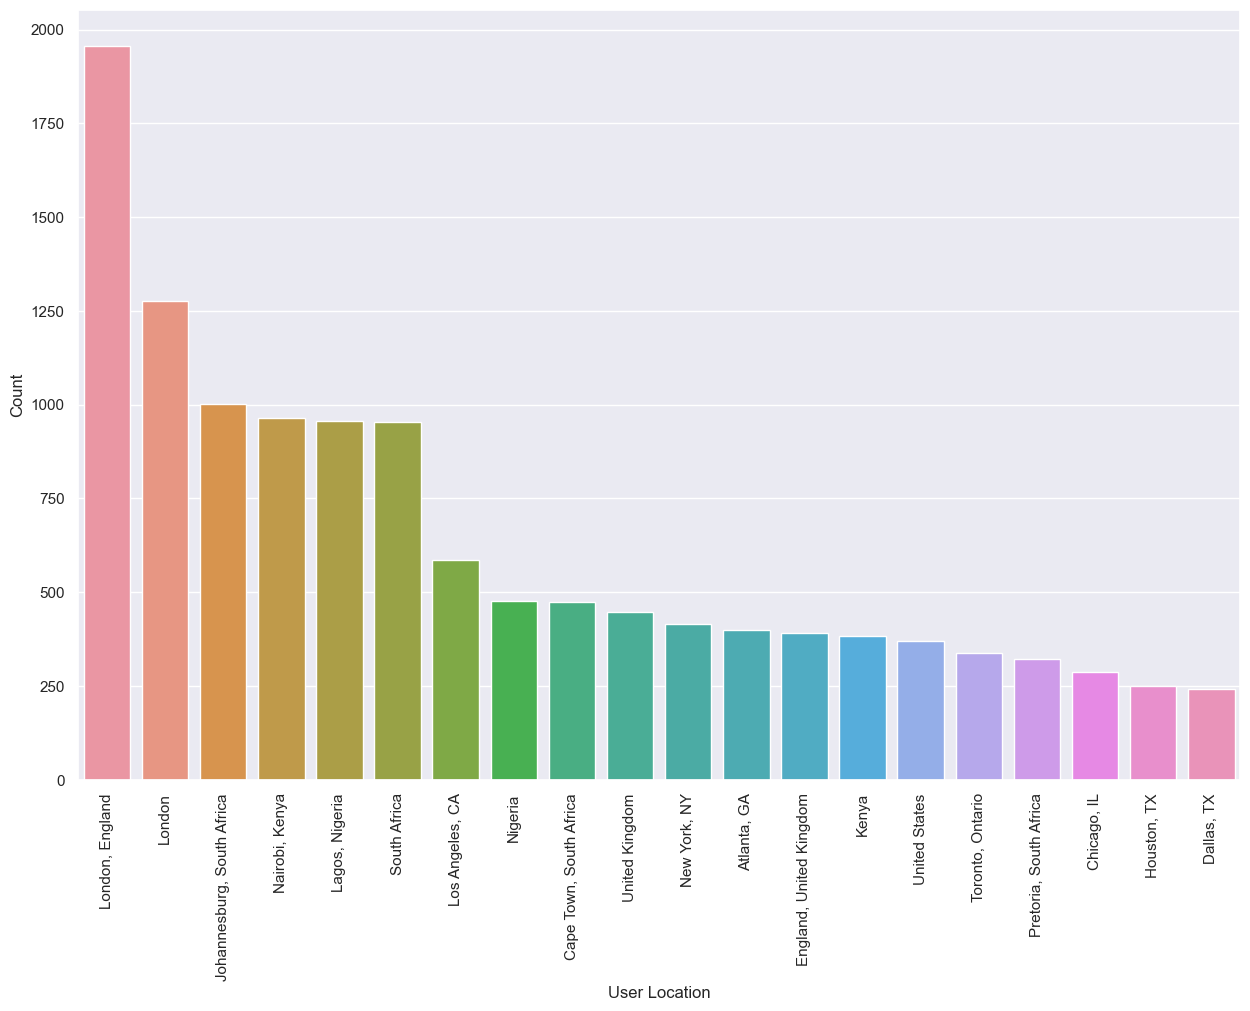

In [363]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="user_location", data=df[df["user_location"] != "unknown"], order=df[df["user_location"] != "unknown"]['user_location'].value_counts().index[0:20])
ax.set_xlabel("User Location")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)

In [227]:
df['datetime_date'] = pd.to_datetime(df['date']).dt.date

In [228]:
df_datecount = df.groupby(by="datetime_date")['datetime_date'].count().reset_index(name="count")

In [229]:
df_datecount

,datetime_date,count
0,2022-02-01,80
1,2022-02-02,3130
2,2022-02-03,6725
3,2022-02-04,9080
4,2022-02-05,13420
5,2022-02-06,14831
6,2022-02-07,11798
7,2022-02-08,11042
8,2022-02-09,6107


Text(0.5, 0, 'Date')

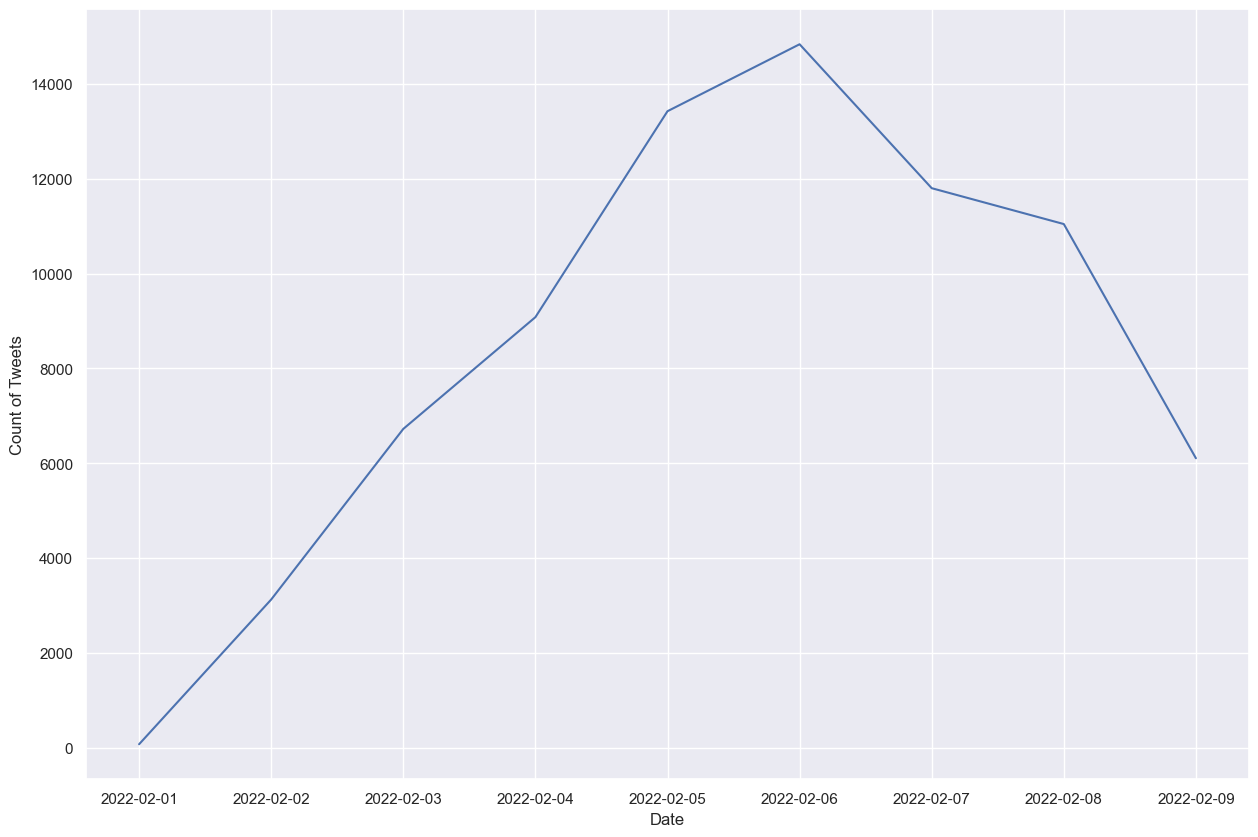

In [230]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_datecount,x=df_datecount["datetime_date"], y=df_datecount['count'].value_counts().index)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Date")

The film was released on Netflix on February 2, 2022

In [378]:
# word count
words = [item for sublist in pre_proccesed_docs for item in sublist]
cv = CountVectorizer().fit(words)
texts_count = cv.transform(words)
sum_words = texts_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)


In [379]:
top_20_words = words_freq[:20]

In [380]:
df_word_freq = pd.DataFrame.from_records(top_20_words, columns = ['word', 'count'])

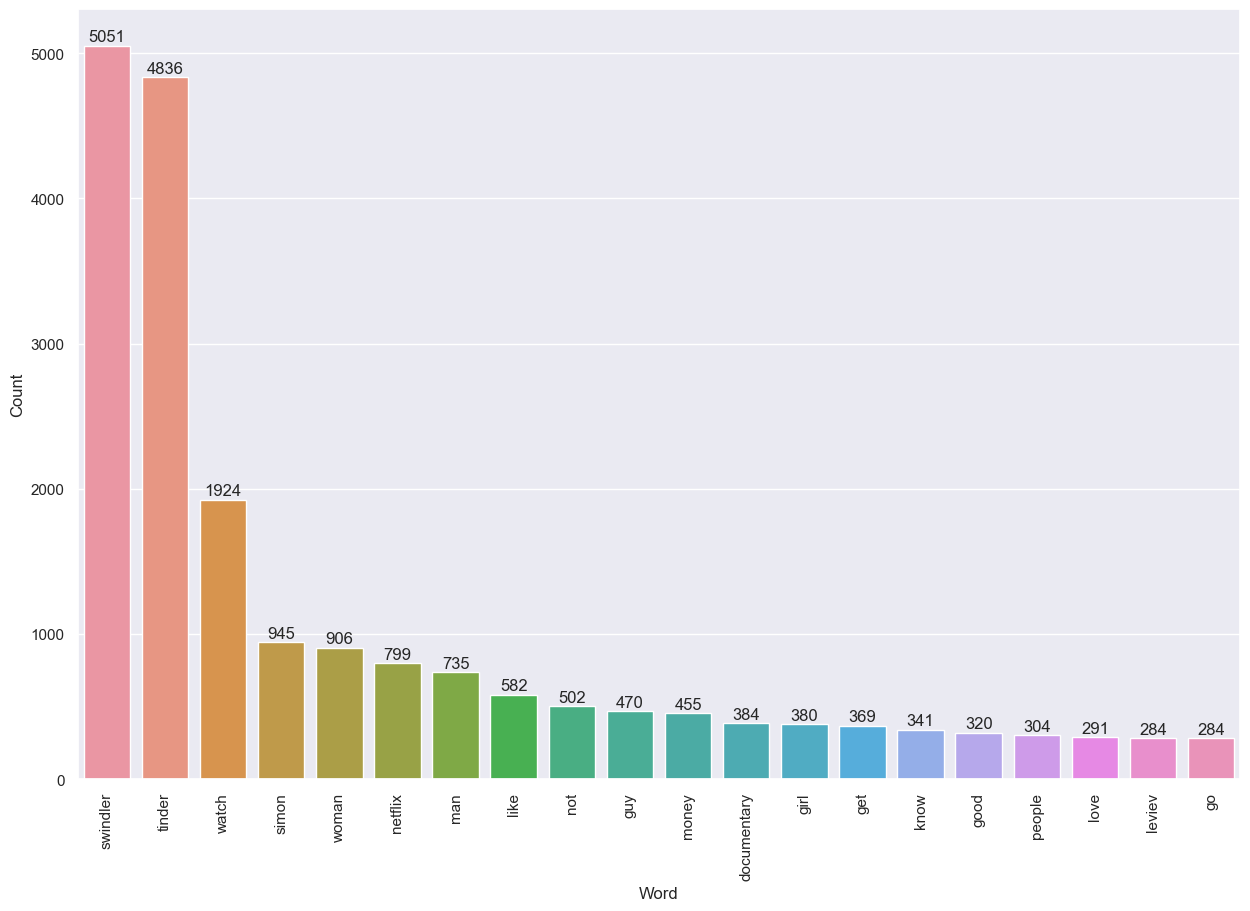

In [381]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="word",y="count", data=df_word_freq)

for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


### Sentiment Analysis

In [ ]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alexanderkneis/nltk_data...


True

In [444]:
preprocess_docs_sentiment = [remove_punct(remove_linebreaks(remove_annotations(remove_hashtag(doc)))) for doc in docs]

In [455]:
preprocess_text_sentiment = []
for doc in preprocess_docs_sentiment:
    doc_text = ""
    for word in doc:
        doc_text = doc_text + word.text
        if doc.index(word) +1 < len(doc):
            doc_text = doc_text + " "
    preprocess_text_sentiment.append(doc_text)

In [458]:
preprocess_text_sentiment[:5]

['I hope they feed this dude to some cannibals',
 'Quick question is Tinder Swindler based off a true story or it ’s just fiction?#tinderswindler',
 'All these Twitter Swindler spoilers ... I was thinking of watching that this weekend',
 '「 」 （ clown_swindler ）',
 'Reigniting the dying spark of love/ Do you still love me     ']

In [459]:
df_preprocessed_text = pd.DataFrame(preprocess_text_sentiment, columns=['text'])

In [460]:
df_preprocessed_text[['polarity', 'subjectivity']] = df_preprocessed_text['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [461]:
for index, row in df_preprocessed_text['text'].items():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_preprocessed_text.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_preprocessed_text.loc[index, 'sentiment'] = "positive"
    else:
        df_preprocessed_text.loc[index, 'sentiment'] = "neutral"
    df_preprocessed_text.loc[index, 'neg'] = neg
    df_preprocessed_text.loc[index, 'neu'] = neu
    df_preprocessed_text.loc[index, 'pos'] = pos
    df_preprocessed_text.loc[index, 'compound'] = comp

In [462]:
df_preprocessed_text.head()

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,I hope they feed this dude to some cannibals,0.000000,0.000,positive,0.0,0.707,0.293,0.4404
1,Quick question is Tinder Swindler based off a ...,0.341667,0.575,positive,0.0,0.823,0.177,0.4215
2,All these Twitter Swindler spoilers ... I was ...,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
3,「 」 （ clown_swindler ）,0.000000,0.000,neutral,0.0,1.000,0.000,0.0000
4,Reigniting the dying spark of love/ Do you sti...,0.500000,0.600,positive,0.0,0.596,0.404,0.7269


In [463]:
df_preprocessed_text_negative = df_preprocessed_text[df_preprocessed_text["sentiment"]=="negative"]
df_preprocessed_text_positive = df_preprocessed_text[df_preprocessed_text["sentiment"]=="positive"]
df_preprocessed_text_neutral = df_preprocessed_text[df_preprocessed_text["sentiment"]=="neutral"]

In [464]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
df_sentiment = count_values_in_column(df_preprocessed_text,"sentiment")

print(df_sentiment)

          Total  Percentage
neutral    3640       36.40
negative   3213       32.13
positive   3147       31.47


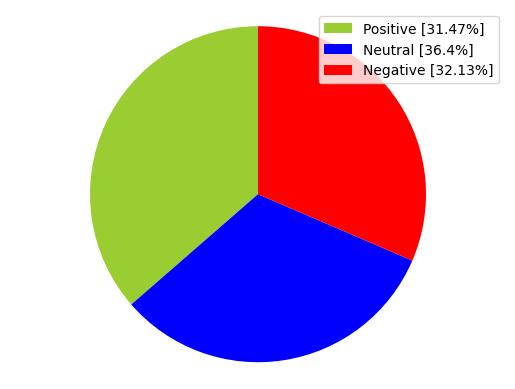

In [465]:
labels = ['Positive ['+str(df_sentiment['Percentage']['positive'])+'%]' , 'Neutral ['+str(df_sentiment['Percentage']['neutral'])+'%]','Negative ['+str(df_sentiment['Percentage']['negative'])+'%]']
sizes = df_sentiment['Percentage']
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.axis('equal')
plt.show()

### LDA

#### Prepare raw text data for lda

In [499]:
# prepare text for lda model
df_lda = pd.DataFrame(df_sample['text'], columns=["text"])
# Remove punctuation
df_lda['text_processed'] = df_lda['text'].map(lambda x: re.sub('[,\.!?\n]', '', x))
# Remove hashtags
df_lda['text_processed'] = df_lda['text_processed'].map(lambda x: re.sub('#\w+|\w+-\w+', '', x))
# Convert the titles to lowercase
df_lda['text_processed'] = df_lda['text_processed'].map(lambda x: x.lower())
# Print out the first rows of df_lda
df_lda['text_processed'].head()

22504         i hope they feed this dude to some cannibals
57472    quick question is tinder swindler based off a ...
54898    all these twitter swindler spoilersi was think...
50702                                 「  」（clown_swindler）
37248    reigniting the dying spark of love/ do you sti...
Name: text_processed, dtype: object

#### Tokenize text

In [505]:

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df_lda.text_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['hope', 'they', 'feed', 'this', 'dude', 'to', 'some', 'cannibals']


#### Buil bigrams and trigrams models

In [506]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

In [507]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [509]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['hope', 'feed', 'dude', 'cannibal']]


#### Data Transformation: Corpus and Dictionary

In [510]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]
